In [1]:
import keras
from keras import backend as K
from keras.applications import VGG16, ResNet50

Using TensorFlow backend.


In [2]:
vgg = VGG16(weights='imagenet', 
            include_top=False, 
            input_shape=(200,200,3))

In [3]:
from keras.layers import Dense, Dropout, Flatten

model = keras.Sequential()
vgg.trainable = False
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

ResNet50 requires at least 197x197 input, so in order to make a fair comparison we'll train both with those dimensions

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_dir = 'databackup/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

# Con batch size de 50 funcionaba mucho mejor, pero lo he tenido que bajar por memoria de la GPU
# Voy a tener que pasarme a colab
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(200,200),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(200,200),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 1550 images belonging to 2 classes.
Found 393 images belonging to 2 classes.


In [5]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = model.fit_generator(train_generator,
                                 steps_per_epoch=50,
                                 epochs=50,
                                 validation_data=validation_generator,
                                 validation_steps=50)

Epoch 1/50
50/50 [==============================] - 41s 814ms/step - loss: 1.3676 - acc: 0.5270 - val_loss: 0.6101 - val_acc: 0.7079
Epoch 2/50
50/50 [==============================] - 36s 716ms/step - loss: 0.6604 - acc: 0.6270 - val_loss: 0.5133 - val_acc: 0.7728
Epoch 3/50
50/50 [==============================] - 37s 731ms/step - loss: 0.5865 - acc: 0.6830 - val_loss: 0.4745 - val_acc: 0.8195
Epoch 4/50
50/50 [==============================] - 37s 740ms/step - loss: 0.4985 - acc: 0.7660 - val_loss: 0.3859 - val_acc: 0.8235
Epoch 5/50
50/50 [==============================] - 42s 841ms/step - loss: 0.5194 - acc: 0.7480 - val_loss: 0.3964 - val_acc: 0.8438
Epoch 6/50
50/50 [==============================] - 37s 736ms/step - loss: 0.5105 - acc: 0.7660 - val_loss: 0.4196 - val_acc: 0.8256
Epoch 7/50
50/50 [==============================] - 37s 749ms/step - loss: 0.4941 - acc: 0.7610 - val_loss: 0.3352 - val_acc: 0.8702
Epoch 8/50
50/50 [==============================] - 38s 754ms/step - 

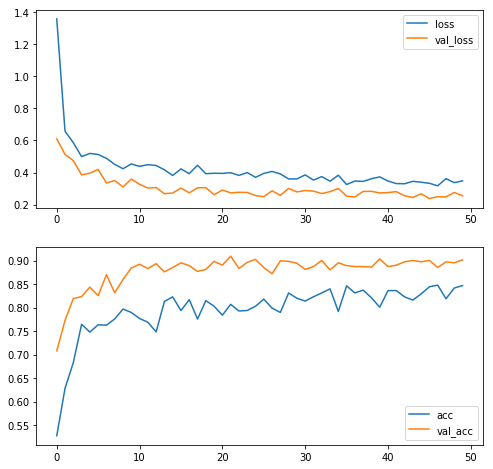

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)


axes[0].plot(history.epoch, history.history['loss'], label='loss')
axes[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(history.epoch, history.history['acc'], label='acc')
axes[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
axes[1].legend()

### Fine Tuning

In [17]:
# The VGG16 inside my model:

model.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [27]:
for layer in model.layers[0].layers:
    if 'block5' in layer.name: 
        layer.trainable = True
    else: 
        layer.trainable = False
        
model.layers[0].trainable = True   

In [29]:
[layer.trainable for layer in model.layers[0].layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

In [30]:
model.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = model.fit_generator(train_generator,
                                 steps_per_epoch=50,
                                 epochs=50,
                                 validation_data=validation_generator,
                                 validation_steps=50)

Epoch 1/50
 5/50 [==>...........................] - ETA: 34s - loss: 4.8734 - acc: 0.6300

ResourceExhaustedError: OOM when allocating tensor with shape[20,64,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: vgg16/block1_conv2/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](vgg16/block1_conv1/Relu, block1_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: flatten_1/Shape/_3315 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_170_flatten_1/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'vgg16/block1_conv2/convolution', defined at:
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-8344027def80>", line 5, in <module>
    model.add(vgg)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/keras/models.py", line 497, in add
    layer(x)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/keras/engine/topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/keras/engine/topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3341, in conv2d
    data_format=tf_data_format)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/dani/anaconda3/envs/keras-playground/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[20,64,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: vgg16/block1_conv2/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](vgg16/block1_conv1/Relu, block1_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: flatten_1/Shape/_3315 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_170_flatten_1/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



### ResNet50

WTF?? It doesn't learn anything transferable at all!!

In [7]:
resnet = ResNet50(weights='imagenet', 
                  include_top=False, 
                  input_shape=(200,200,3))


resnet.trainable = False

othermodel = keras.Sequential()
othermodel.add(resnet)
othermodel.add(Flatten())
othermodel.add(Dense(256, activation='relu'))
othermodel.add(Dropout(0.5))
othermodel.add(Dense(128, activation='relu'))
othermodel.add(Dropout(0.5))
othermodel.add(Dense(64, activation='relu'))
othermodel.add(Dropout(0.5))
othermodel.add(Dense(1, activation='sigmoid'))

othermodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
__________

In [8]:
othermodel.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = othermodel.fit_generator(train_generator,
                                 steps_per_epoch=50,
                                 epochs=50,
                                 validation_data=validation_generator,
                                 validation_steps=50)

Epoch 1/50
50/50 [==============================] - 66s 1s/step - loss: 0.7399 - acc: 0.6550 - val_loss: 0.7959 - val_acc: 0.5578
Epoch 2/50
50/50 [==============================] - 104s 2s/step - loss: 0.4711 - acc: 0.7990 - val_loss: 1.0830 - val_acc: 0.5639
Epoch 3/50
50/50 [==============================] - 103s 2s/step - loss: 0.3589 - acc: 0.8550 - val_loss: 1.0179 - val_acc: 0.5629
Epoch 4/50
50/50 [==============================] - 101s 2s/step - loss: 0.3335 - acc: 0.8540 - val_loss: 1.5082 - val_acc: 0.5619
Epoch 5/50
50/50 [==============================] - 29s 575ms/step - loss: 0.3265 - acc: 0.8850 - val_loss: 1.5091 - val_acc: 0.5578
Epoch 6/50
50/50 [==============================] - 29s 571ms/step - loss: 0.3004 - acc: 0.8770 - val_loss: 1.4894 - val_acc: 0.5649
Epoch 7/50
50/50 [==============================] - 30s 597ms/step - loss: 0.2770 - acc: 0.8850 - val_loss: 1.0093 - val_acc: 0.5568
Epoch 8/50
50/50 [==============================] - 31s 611ms/step - loss: 0.3

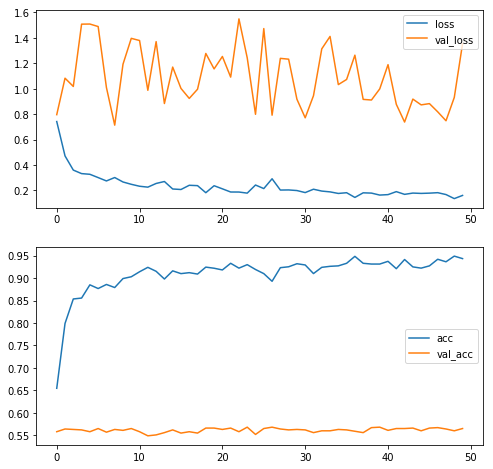

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)


axes[0].plot(history.epoch, history.history['loss'], label='loss')
axes[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(history.epoch, history.history['acc'], label='acc')
axes[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
axes[1].legend()